# Reading p0f log files with pandas

We want to use unsupervised learning on signature logs generated by a `p0f` sensor. 
This will help cluster co-occurring data points together and help in detecting outliers (novelty).
In the first cell below, we import libraries that are useful.

In [1]:
import pandas as pd
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.manifold import TSNE

Let's create a dataframe from the two available `p0f` log files.

We first read the entries from each log into a different list.

In [2]:
with open('p0f1.log', 'r') as logfile1:
    log1 = logfile1.readlines()

with open('p0f2.log', 'r') as logfile2:
    log2 = logfile2.readlines()

We define the `log_to_json()` function to parse each log entry and store an entry as a collection of key-value pairs into a dictionary, where the index is the entry number. 

In [3]:
def log_to_json(jsondata:dict, logs:list[str]) -> dict:
    i = len(jsondata)
    for line in logs:
        twofields = re.split(r'\[|\]', line)
        datetimestr = twofields[1]
        columns = re.split(r'\|', twofields[2])
        data = {}
        data["timestamp"] = datetimestr.strip()
        for column in columns:
            info = column.split('=')
            key = info[0].strip()
            value = info[1].strip()
            data[key] = value
        jsondata[i] = data
        i += 1

    return jsondata


We combine two collections of json data from two files into one dictionary `jsondata`.

We use the `read_json()` method in `pandas` library to read it into a dataframe.

In [4]:
jsondata = {}
jsondata = log_to_json(jsondata, log1)
jsondata = log_to_json(jsondata, log2)

jsonfile = json.dumps(jsondata)

dflog = pd.read_json(jsonfile, orient='index')
dflog.tail()

C:\Users\SubCom\AppData\Local\Temp\ipykernel_11672\3370604999.py:7: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dflog = pd.read_json(jsonfile, orient='index')


,timestamp,mod,cli,srv,subj,os,dist,params,raw_sig,link,raw_mtu,uptime,raw_freq,reason,raw_hits,app,lang
21353,2023-03-24 10:46:34,mtu,192.168.0.200/55590,169.148.148.126/443,srv,NaN,NaN,NaN,NaN,Ethernet or modem,1500.0,NaN,NaN,NaN,NaN,NaN,NaN
21354,2023-03-24 10:46:34,syn,192.168.0.200/55591,106.51.145.246/443,cli,Mac OS X,0.0,generic fuzzy,"4:64+0:0:1460:65535,6:mss,nop,ws,nop,nop,ts,so...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21355,2023-03-24 10:46:34,mtu,192.168.0.200/55591,106.51.145.246/443,cli,NaN,NaN,NaN,NaN,Ethernet or modem,1500.0,NaN,NaN,NaN,NaN,NaN,NaN
21356,2023-03-24 10:46:34,syn+ack,192.168.0.200/55591,106.51.145.246/443,srv,???,6.0,none,"4:58+6:0:1460:mss*45,7:mss,sok,ts,nop,ws:df,ecn:0",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21357,2023-03-24 10:46:34,mtu,192.168.0.200/55591,106.51.145.246/443,srv,NaN,NaN,NaN,NaN,Ethernet or modem,1500.0,NaN,NaN,NaN,NaN,NaN,NaN


The above dataframe can be modified to identify the first column as a `pd.Timestamp` datatype and use it as the index column.

In [5]:
dflog["timestamp"] = pd.to_datetime(dflog["timestamp"])
dflog.set_index("timestamp", inplace=True)
dflog.head()

,mod,cli,srv,subj,os,dist,params,raw_sig,link,raw_mtu,uptime,raw_freq,reason,raw_hits,app,lang
timestamp,,,,,,,,,,,,,,,,
2023-03-23 10:49:31,syn,192.168.0.200/50316,35.241.9.150/443,cli,Mac OS X,0.0,generic fuzzy,"4:64+0:0:1460:65535,6:mss,nop,ws,nop,nop,ts,so...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-23 10:49:31,mtu,192.168.0.200/50316,35.241.9.150/443,cli,NaN,NaN,NaN,NaN,Ethernet or modem,1500.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-23 10:49:31,syn+ack,192.168.0.200/50316,35.241.9.150/443,srv,???,9.0,none,"4:119+9:0:1412:65535,8:mss,sok,ts,nop,ws:df:0",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-23 10:49:31,mtu,192.168.0.200/50316,35.241.9.150/443,srv,NaN,NaN,NaN,NaN,DSL,1452.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-23 10:49:31,uptime,192.168.0.200/50316,35.241.9.150/443,cli,NaN,NaN,NaN,NaN,NaN,NaN,46 days 4 hrs 32 min (modulo 49 days),1018.52 Hz,NaN,NaN,NaN,NaN


### Identifying numeric columns

Columns `uptime` and `raw_freq` need cleaning.

In [6]:
dflog["raw_freq"].fillna('0 Hz', inplace=True)
dflog['raw_freq']= dflog['raw_freq'].str[0:-3].astype(float)
dflog.rename(columns={"raw_freq":"raw_freq_Hz"}, inplace=True)
dflog.head()

,mod,cli,srv,subj,os,dist,params,raw_sig,link,raw_mtu,uptime,raw_freq_Hz,reason,raw_hits,app,lang
timestamp,,,,,,,,,,,,,,,,
2023-03-23 10:49:31,syn,192.168.0.200/50316,35.241.9.150/443,cli,Mac OS X,0.0,generic fuzzy,"4:64+0:0:1460:65535,6:mss,nop,ws,nop,nop,ts,so...",NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN
2023-03-23 10:49:31,mtu,192.168.0.200/50316,35.241.9.150/443,cli,NaN,NaN,NaN,NaN,Ethernet or modem,1500.0,NaN,0.00,NaN,NaN,NaN,NaN
2023-03-23 10:49:31,syn+ack,192.168.0.200/50316,35.241.9.150/443,srv,???,9.0,none,"4:119+9:0:1412:65535,8:mss,sok,ts,nop,ws:df:0",NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN
2023-03-23 10:49:31,mtu,192.168.0.200/50316,35.241.9.150/443,srv,NaN,NaN,NaN,NaN,DSL,1452.0,NaN,0.00,NaN,NaN,NaN,NaN
2023-03-23 10:49:31,uptime,192.168.0.200/50316,35.241.9.150/443,cli,NaN,NaN,NaN,NaN,NaN,NaN,46 days 4 hrs 32 min (modulo 49 days),1018.52,NaN,NaN,NaN,NaN


We derive numeric columns from the `uptime` column.

In [7]:
dflog['uptime'].fillna('0 days 0 hrs 0 min (modulo 0 days)', inplace=True)
dflog[['uptime_days', 'x0', 'uptime_hrs', 'x1', 'uptime_mins', 'x2', 'x3', 'uptime_cycle_days', 'x4']] = dflog['uptime'].str.split(' ', n=8, expand=True)
dflog.drop(columns=['uptime','x0', 'x1', 'x2', 'x3', 'x4'], inplace=True)
dflog.head()


,mod,cli,srv,subj,os,dist,params,raw_sig,link,raw_mtu,raw_freq_Hz,reason,raw_hits,app,lang,uptime_days,uptime_hrs,uptime_mins,uptime_cycle_days
timestamp,,,,,,,,,,,,,,,,,,,
2023-03-23 10:49:31,syn,192.168.0.200/50316,35.241.9.150/443,cli,Mac OS X,0.0,generic fuzzy,"4:64+0:0:1460:65535,6:mss,nop,ws,nop,nop,ts,so...",NaN,NaN,0.00,NaN,NaN,NaN,NaN,0,0,0,0
2023-03-23 10:49:31,mtu,192.168.0.200/50316,35.241.9.150/443,cli,NaN,NaN,NaN,NaN,Ethernet or modem,1500.0,0.00,NaN,NaN,NaN,NaN,0,0,0,0
2023-03-23 10:49:31,syn+ack,192.168.0.200/50316,35.241.9.150/443,srv,???,9.0,none,"4:119+9:0:1412:65535,8:mss,sok,ts,nop,ws:df:0",NaN,NaN,0.00,NaN,NaN,NaN,NaN,0,0,0,0
2023-03-23 10:49:31,mtu,192.168.0.200/50316,35.241.9.150/443,srv,NaN,NaN,NaN,NaN,DSL,1452.0,0.00,NaN,NaN,NaN,NaN,0,0,0,0
2023-03-23 10:49:31,uptime,192.168.0.200/50316,35.241.9.150/443,cli,NaN,NaN,NaN,NaN,NaN,NaN,1018.52,NaN,NaN,NaN,NaN,46,4,32,49


`dist` and `raw_mtu` should be numeric columns. We get rid of `NaN`s in these columns to later change their datatype.

In [8]:
dflog['dist'].fillna(0.0, inplace=True)
dflog['raw_mtu'].fillna(0.0, inplace=True)
dflog.head()

,mod,cli,srv,subj,os,dist,params,raw_sig,link,raw_mtu,raw_freq_Hz,reason,raw_hits,app,lang,uptime_days,uptime_hrs,uptime_mins,uptime_cycle_days
timestamp,,,,,,,,,,,,,,,,,,,
2023-03-23 10:49:31,syn,192.168.0.200/50316,35.241.9.150/443,cli,Mac OS X,0.0,generic fuzzy,"4:64+0:0:1460:65535,6:mss,nop,ws,nop,nop,ts,so...",NaN,0.0,0.00,NaN,NaN,NaN,NaN,0,0,0,0
2023-03-23 10:49:31,mtu,192.168.0.200/50316,35.241.9.150/443,cli,NaN,0.0,NaN,NaN,Ethernet or modem,1500.0,0.00,NaN,NaN,NaN,NaN,0,0,0,0
2023-03-23 10:49:31,syn+ack,192.168.0.200/50316,35.241.9.150/443,srv,???,9.0,none,"4:119+9:0:1412:65535,8:mss,sok,ts,nop,ws:df:0",NaN,0.0,0.00,NaN,NaN,NaN,NaN,0,0,0,0
2023-03-23 10:49:31,mtu,192.168.0.200/50316,35.241.9.150/443,srv,NaN,0.0,NaN,NaN,DSL,1452.0,0.00,NaN,NaN,NaN,NaN,0,0,0,0
2023-03-23 10:49:31,uptime,192.168.0.200/50316,35.241.9.150/443,cli,NaN,0.0,NaN,NaN,NaN,0.0,1018.52,NaN,NaN,NaN,NaN,46,4,32,49


Examine the `raw_hits` column.

In [9]:
dflog['raw_hits'].unique()

array([nan, '0,1,1,1', '0,2,2,2', '0,3,3,3', '1,1,1,1', '1,2,2,2',
       '2,3,3,3', '2,2,2,2', '3,3,3,3', '2,4,4,4', '2,5,5,5', '0,4,4,4',
       '3,4,4,4', '1,5,5,5', '1,3,3,3', '1,4,4,4', '0,5,5,5', '0,0,1,1',
       '0,0,2,2', '0,1,2,2', '1,1,2,2', '1,2,3,3', '3,5,5,5', '1,3,4,4',
       '0,2,3,3', '0,0,3,3', '0,0,4,4', '0,0,5,5', '0,0,6,6', '0,0,7,7',
       '2,2,3,3', '1,1,3,3', '2,2,4,4', '3,3,5,5', '3,3,4,4', '1,3,5,5',
       '1,3,6,6', '1,4,7,7'], dtype=object)

We split this column into four numeric ones, in a manner similar to the `uptime` column.

In [10]:
dflog['raw_hits'].fillna('0,0,0,0', inplace=True)
dflog[['raw_hits_0', 'raw_hits_1', 'raw_hits_2', 'raw_hits_3']] = dflog['raw_hits'].str.split(',', n=3, expand=True)
dflog.drop(columns=['raw_hits'], inplace=True)
dflog.head()

,mod,cli,srv,subj,os,dist,params,raw_sig,link,raw_mtu,...,app,lang,uptime_days,uptime_hrs,uptime_mins,uptime_cycle_days,raw_hits_0,raw_hits_1,raw_hits_2,raw_hits_3
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-23 10:49:31,syn,192.168.0.200/50316,35.241.9.150/443,cli,Mac OS X,0.0,generic fuzzy,"4:64+0:0:1460:65535,6:mss,nop,ws,nop,nop,ts,so...",NaN,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
2023-03-23 10:49:31,mtu,192.168.0.200/50316,35.241.9.150/443,cli,NaN,0.0,NaN,NaN,Ethernet or modem,1500.0,...,NaN,NaN,0,0,0,0,0,0,0,0
2023-03-23 10:49:31,syn+ack,192.168.0.200/50316,35.241.9.150/443,srv,???,9.0,none,"4:119+9:0:1412:65535,8:mss,sok,ts,nop,ws:df:0",NaN,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
2023-03-23 10:49:31,mtu,192.168.0.200/50316,35.241.9.150/443,srv,NaN,0.0,NaN,NaN,DSL,1452.0,...,NaN,NaN,0,0,0,0,0,0,0,0
2023-03-23 10:49:31,uptime,192.168.0.200/50316,35.241.9.150/443,cli,NaN,0.0,NaN,NaN,NaN,0.0,...,NaN,NaN,46,4,32,49,0,0,0,0


The new columns derived from `uptime` and `raw_hits` columns should be of numeric type.

In [11]:
cols = ['uptime_days', 'uptime_hrs', 'uptime_mins', 'uptime_cycle_days', 'raw_hits_0', 'raw_hits_1', 'raw_hits_2', 'raw_hits_3']
dflog[cols] = dflog[cols].apply(pd.to_numeric, errors='coerce', axis=1)
dflog.dtypes

mod                   object
cli                   object
srv                   object
subj                  object
os                    object
dist                 float64
params                object
raw_sig               object
link                  object
raw_mtu              float64
raw_freq_Hz          float64
reason                object
app                   object
lang                  object
uptime_days            int64
uptime_hrs             int64
uptime_mins            int64
uptime_cycle_days      int64
raw_hits_0             int64
raw_hits_1             int64
raw_hits_2             int64
raw_hits_3             int64
dtype: object

### Processing non-numeric columns

`NaN`s are unsightly and make it difficult to process non-numeric columns since they are `float64` type. We replace `NaN`s in non-numeric columns with the string `unknown`.

In [12]:
non_numeric_cols = dflog.select_dtypes(exclude=[int, float])
for column in non_numeric_cols:
    dflog[column].fillna('unknown', inplace=True)
    dflog[column].mask(dflog[column]=='???', 'unknown', inplace=True)
dflog.head()

,mod,cli,srv,subj,os,dist,params,raw_sig,link,raw_mtu,...,app,lang,uptime_days,uptime_hrs,uptime_mins,uptime_cycle_days,raw_hits_0,raw_hits_1,raw_hits_2,raw_hits_3
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-23 10:49:31,syn,192.168.0.200/50316,35.241.9.150/443,cli,Mac OS X,0.0,generic fuzzy,"4:64+0:0:1460:65535,6:mss,nop,ws,nop,nop,ts,so...",unknown,0.0,...,unknown,unknown,0,0,0,0,0,0,0,0
2023-03-23 10:49:31,mtu,192.168.0.200/50316,35.241.9.150/443,cli,unknown,0.0,unknown,unknown,Ethernet or modem,1500.0,...,unknown,unknown,0,0,0,0,0,0,0,0
2023-03-23 10:49:31,syn+ack,192.168.0.200/50316,35.241.9.150/443,srv,unknown,9.0,none,"4:119+9:0:1412:65535,8:mss,sok,ts,nop,ws:df:0",unknown,0.0,...,unknown,unknown,0,0,0,0,0,0,0,0
2023-03-23 10:49:31,mtu,192.168.0.200/50316,35.241.9.150/443,srv,unknown,0.0,unknown,unknown,DSL,1452.0,...,unknown,unknown,0,0,0,0,0,0,0,0
2023-03-23 10:49:31,uptime,192.168.0.200/50316,35.241.9.150/443,cli,unknown,0.0,unknown,unknown,unknown,0.0,...,unknown,unknown,46,4,32,49,0,0,0,0


## Feature Selection using Visualization
In presence of a large number of features, it always make sense to identify the important features in the dataframe.
We do this by first visualizing feature importance in a feature matrix, as shown in [this](https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b) article.

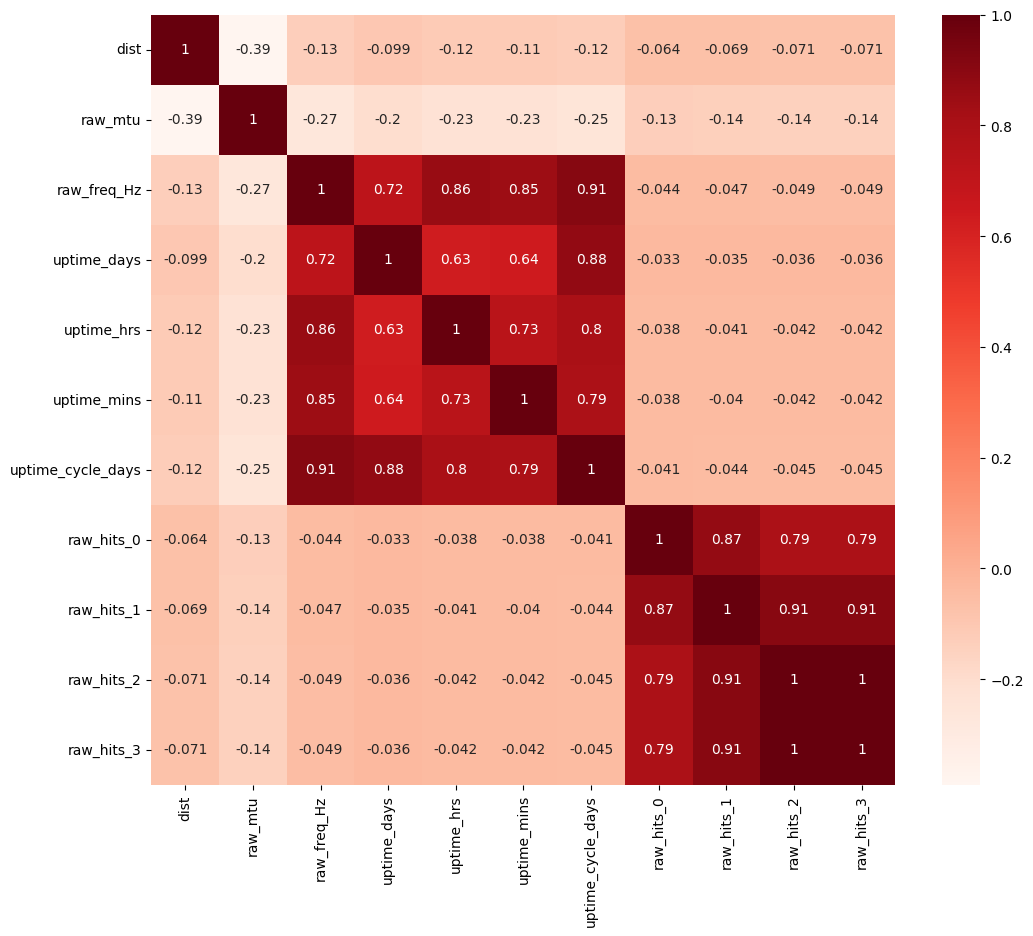

In [13]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
dfnums = dflog.select_dtypes(include=np.number)
cor = dfnums.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

We can observe that features `raw_freq_Hz` and features constructed from `uptime` show high correlation.
However, there is no other correlation to observe among other pairs of variables not derived from the same original column.
Therefore, we will not be reducing the number of features to train upon.

# Constructing the SOM Model

In this section we will construct the 2D lattice (3-dimensional in the implementation, to represent the peaks and troughs on the 2D surface) for our SOM.
## One-hot Encoding
We will apply one-hot encoding to the data to get numeric-valued columns.

In [14]:
dfoh = pd.get_dummies(dflog, columns=['mod', 'cli', 'srv', 'subj', 'os', 'params', 'raw_sig', 'reason', 'app', 'lang', 'link'])
dfoh.head()

,dist,raw_mtu,raw_freq_Hz,uptime_days,uptime_hrs,uptime_mins,uptime_cycle_days,raw_hits_0,raw_hits_1,raw_hits_2,...,lang_none,lang_unknown,link_DSL,link_Ethernet or modem,link_GIF,link_IPIP or SIT,link_IPSec or GRE,link_VLAN,link_generic tunnel or VPN,link_unknown
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-23 10:49:31,0.0,0.0,0.00,0,0,0,0,0,0,0,...,False,True,False,False,False,False,False,False,False,True
2023-03-23 10:49:31,0.0,1500.0,0.00,0,0,0,0,0,0,0,...,False,True,False,True,False,False,False,False,False,False
2023-03-23 10:49:31,9.0,0.0,0.00,0,0,0,0,0,0,0,...,False,True,False,False,False,False,False,False,False,True
2023-03-23 10:49:31,0.0,1452.0,0.00,0,0,0,0,0,0,0,...,False,True,True,False,False,False,False,False,False,False
2023-03-23 10:49:31,0.0,0.0,1018.52,46,4,32,49,0,0,0,...,False,True,False,False,False,False,False,False,False,True


In [15]:
len(dfoh)

21358

In [16]:
train, test = train_test_split(dfoh, test_size=0.2)
print(len(train), len(test))

17086 4272


## Training the SOM

First we define some helper functions in the cell below, followed by hyperparameters, and subsequently, a function that, when called, trains the SOM with the pre-defined hyperparameters. This code is imported from Ken Marawaki's tutorial on SOMs from the Towards Data Science [blog](https://towardsdatascience.com/understanding-self-organising-map-neural-network-with-python-code-7a77f501e985).

The uses of the helper functions below are explained in the blog as follows:
- `minmax_scaler` is used to normalise the input data between 0 and 1. 
Because the algorithm calculates the distance, we should scale the values of each feature to the same range to avoid any of them having a greater impact on the distance calculation than other features.

- `e_distance` calculates the _Euclidean distance_ between the two points. In our example, the Euclidean distance is used to search for the winning neuron.

- `m_distance` is for obtaining the rectangular _Manhattan distance_ between two points on the grid.  The _Manhattan distance_ is used to limit the neighbourhood range of the winner neuron. 
It simplifies the computation by applying the rectangular neighbourhood function where the neurons located within a certain Manhattan distance from the topological location of the BMU are activated at the same level.

- `winning_neuron` searches for the BMU (Best Matching Unit) for a sample data `t`. The distance between the input signal and every neuron in the map layer is calculated and the row and column index of the grid of the neuron with the shortest distance is returned.

- `decay` returns the _learning rate_ and _neighbourhood range_ after applying linear decay, using the input arguments _current training step_, _maximum number of training steps_, _maximum neighbourhood range_ and the _maximum learning rate_.

#### Helper Functions

In [17]:
# Helper functions

# Data Normalisation
def minmax_scaler(data):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(data)
  return scaled

# Euclidean distance
def e_distance(x,y):
  return distance.euclidean(x,y)

# Manhattan distance
def m_distance(x,y):
  return distance.cityblock(x,y)

# Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
  for row in range(num_rows):
    for col in range(num_cols):
      distance = e_distance(som[row][col], data[t])
      if distance < shortest_distance: 
        shortest_distance = distance
        winner = [row,col]
  return winner

# Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_distance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_distance)
  return learning_rate, neighbourhood_range

#### Hyperparameters

In [18]:
# hyperparameters
num_rows = 13
num_cols = 13
max_manhattan_distance = 4
max_learning_rate = 0.5
max_steps = int(7.5*10e3)

# num_neurons = 5*np.sqrt(train.shape[0])
# grid_size = ceil(np.sqrt(num_neurons))
# num_rows = int(grid_size)
# num_cols = int(grid_size)
# print(grid_size)

#### The Training Function

In [19]:
train_norm = minmax_scaler(train) # normalisation

In [20]:
#main function
# initialising self-organising map
num_dims = train_norm.shape[1] # numnber of dimensions in the input data
np.random.seed(40)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

# start training iterations
for step in range(max_steps):
  if (step+1) % 1000 == 0:
    print("Iteration: ", step+1) # print out the current iteration for every 1k
  learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_manhattan_distance)

  t = np.random.randint(0,high=train_norm.shape[0]) # random index of training data
  winner = winning_neuron(train_norm, t, som, num_rows, num_cols)
  for row in range(num_rows):
    for col in range(num_cols):
      if m_distance([row,col],winner) <= neighbourhood_range:
        som[row][col] += learning_rate*(train_norm[t]-som[row][col]) #update neighbour's weight

print("SOM training completed")

Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
Iteration:  11000
Iteration:  12000
Iteration:  13000
Iteration:  14000
Iteration:  15000
Iteration:  16000
Iteration:  17000
Iteration:  18000
Iteration:  19000
Iteration:  20000
Iteration:  21000
Iteration:  22000
Iteration:  23000
Iteration:  24000
Iteration:  25000
Iteration:  26000
Iteration:  27000
Iteration:  28000
Iteration:  29000
Iteration:  30000
Iteration:  31000
Iteration:  32000
Iteration:  33000
Iteration:  34000
Iteration:  35000
Iteration:  36000
Iteration:  37000
Iteration:  38000
Iteration:  39000
Iteration:  40000
Iteration:  41000
Iteration:  42000
Iteration:  43000
Iteration:  44000
Iteration:  45000
Iteration:  46000
Iteration:  47000
Iteration:  48000
Iteration:  49000
Iteration:  50000
Iteration:  51000
Iteration:  52000
Iteration:  53000
Iteration:  54000
Iteration:  55000
Iteration:  56000
I

In [21]:
print(som.shape)

(13, 13, 4999)


# Plot SOM lattice after training and testing

In [55]:
def plot(som, num_rows, num_cols, num_dims):
    x = np.arange(num_rows)
    y = np.arange(num_cols)
    z = np.arange(num_dims)
    x, y, z = np.meshgrid(x,y,z)

    npsom = np.array(som)
    #c = np.tile(npsom.ravel()[:, None], [1, 3])
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.scatter(x.ravel(),
               y.ravel(),
               z.ravel(),
            c=npsom[x, y, z])
    ax.set_xlabel("num_rows")
    ax.set_ylabel("num_cols")
    ax.set_title("Surface of the Map")
    plt.show()

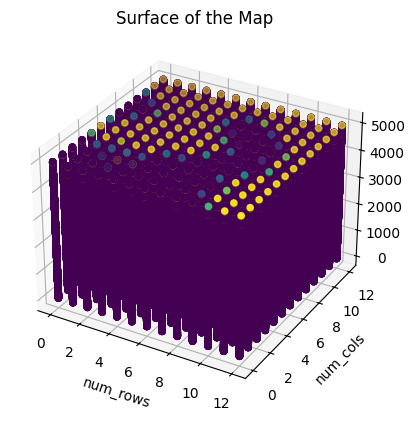

In [56]:
plot(som, num_rows, num_cols, num_dims)

## Testing SOM
The objective is to run the algorithm on the test set to view changes, if any, in the SOM lattice.
First, we normalize the test data, same way as the train data.

In [57]:
# test data
test_norm = minmax_scaler(test) # normalisation

Fitting/inducing movements in the SOM lattice for every sample in the normalized test data.

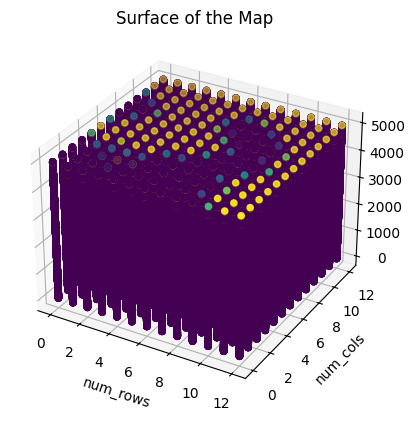

In [58]:
# using the trained som, search the winning node of corresponding to the test data
# get the label of the winning node
for t in range(test_norm.shape[0]):
 winner = winning_neuron(test_norm, t, som, num_rows, num_cols)
 row = winner[0]
 col = winner[1]

plot(som, num_rows, num_cols, num_dims)

# Novelty Detection using One-Class SVM

In [59]:
# reduce the data to 2 dimensions using t-SNE
train_reduced = TSNE(n_components=2, random_state=0).fit_transform(train_norm)

# fit the model to the reduced data
svm = OneClassSVM(kernel='rbf', nu=0.045, gamma='auto')
svm.fit(train_reduced)

OneClassSVM(gamma='auto', nu=0.045)

In [60]:
# extract the model predictions
train_predicted = svm.predict(train_reduced)

In [61]:
num_outliers = 0
for i in train_predicted:
    if i==-1: num_outliers += 1
print("train data:", num_outliers, len(train_predicted))

train data: 5006 17086


In [62]:
def plot_svm(reduced_data, predictions):
    # define the meshgrid
    x_min, x_max = reduced_data[:, 0].min() - 5, reduced_data[:, 0].max() + 5
    y_min, y_max = reduced_data[:, 1].min() - 5, reduced_data[:, 1].max() + 5

    x_ = np.linspace(x_min, x_max, 500)
    y_ = np.linspace(y_min, y_max, 500)

    xx, yy = np.meshgrid(x_, y_)

    # evaluate the decision function on the meshgrid
    z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)

    # plot the decision function and the reduced data
    plt.contourf(xx, yy, z, cmap=plt.cm.PuBu)
    a = plt.contour(xx, yy, z, levels=[0], linewidths=2, colors='darkred')
    b = plt.scatter(reduced_data[predictions == 1, 0], reduced_data[predictions == 1, 1], c='white', edgecolors='k', label = 'regular observations')
    c = plt.scatter(reduced_data[predictions == -1, 0], reduced_data[predictions == -1, 1], c='gold', edgecolors='k', label = 'abnormal observations')
    #plist = a.collections
    #plt.legend([plist[0] , b, c], ['learned frontier', 'regular observations', 'abnormal observations'], bbox_to_anchor=(1.05, 1))

    circ1 = Line2D([0], [0], linestyle="none", marker="_", alpha=0.4, markersize=10, markeredgecolor="darkred")
    circ2 = Line2D([0], [0], linestyle="none", marker="o", alpha=0.3, markersize=10, markerfacecolor="white")
    circ3 = Line2D([0], [0], linestyle="none", marker="o", alpha=0.4, markersize=10, markerfacecolor="gold")

    plt.legend((circ1, circ2, circ3), ('learned frontier', 'regular observations', 'abnormal observations'), bbox_to_anchor=(1.05, 1))


    plt.axis('tight')
    plt.show()

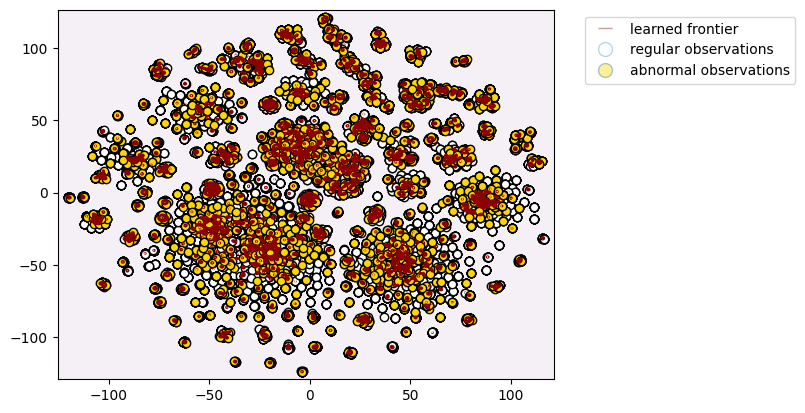

In [63]:
plot_svm(train_reduced, train_predicted)

## One-class SVM on SOM lattice

In [64]:
# reduce the data to 2 dimensions using t-SNE
npsom = np.array(som)
npsom = np.reshape(npsom, (npsom.shape[0]*npsom.shape[1], npsom.shape[2]))
som_reduced = TSNE(n_components=2, random_state=0, perplexity = 50).fit_transform(npsom)

# fit the model to the reduced data
svm = OneClassSVM(kernel='rbf', nu=0.045, gamma='auto')
svm.fit(som_reduced)

OneClassSVM(gamma='auto', nu=0.045)

In [65]:
# extract the model predictions
som_predicted = svm.predict(som_reduced)

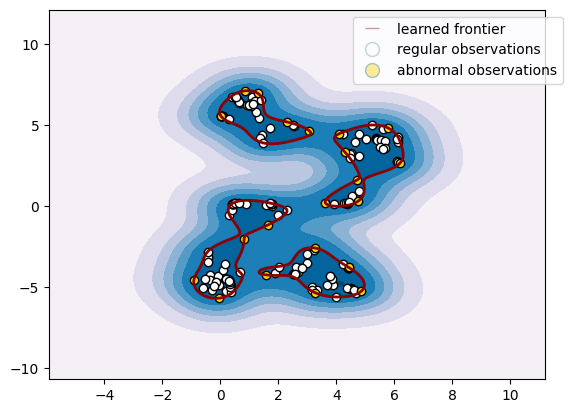

In [66]:
plot_svm(som_reduced, som_predicted)